## Stock Price Prediction using LSTM, GRU and BiLSTM with Feature Engineering and Hyperparameter Tuning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import StackingRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Bidirectional, Dropout
import keras.optimizers as optimizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.base import RegressorMixin, BaseEstimator
import tensorflow as tf
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download historical stock data
ticker = "GOOGL"
start_date = "2018-01-01"
end_date = "2023-10-31"

df = yf.download(ticker, start=start_date, end=end_date, progress=False)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000
...,...,...,...,...,...,...
2023-10-24,137.830002,139.360001,137.419998,138.809998,138.809998,44814300
2023-10-25,128.160004,128.309998,125.070000,125.610001,125.610001,84366200
2023-10-26,123.269997,124.330002,121.269997,122.279999,122.279999,57061100


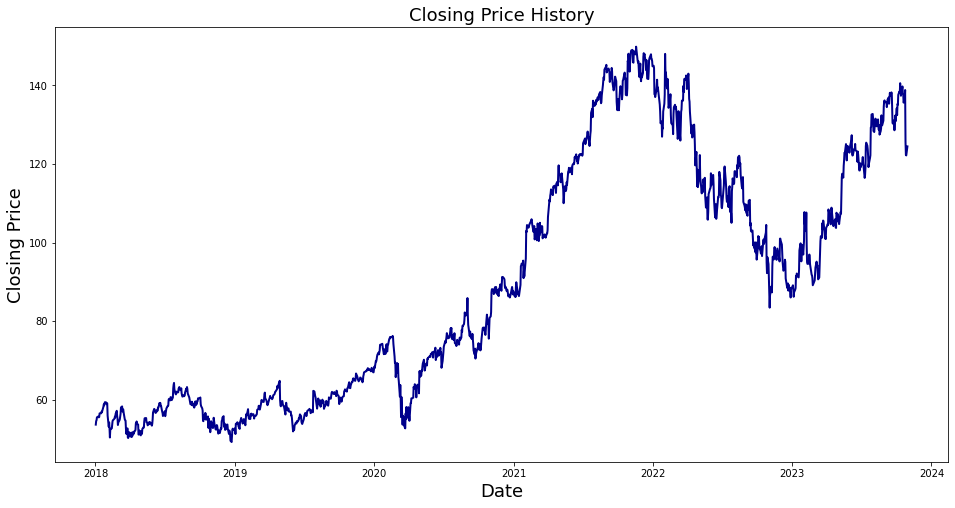

In [3]:
# Plot the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History', fontsize=18)
plt.plot(df['Close'], linewidth=2, color='darkblue')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.show()

In [4]:
# Feature Engineering
df['Return'] = df['Close'].pct_change() # Simple daily return
df['Moving_Avg_5'] = df['Close'].rolling(window=5).mean() # 5-day moving average
df['Moving_Avg_10'] = df['Close'].rolling(window=10).mean() # 10-day moving average
df['Moving_STD_10'] = df['Close'].rolling(window=10).std() # 10-day moving standard deviation

# Replace NA values with 0
df.fillna(0, inplace=True)

df.head(30)

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000,0.000000,0.000000,0.000000,0.000000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000,0.017061,0.000000,0.000000,0.000000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000,0.003884,0.000000,0.000000,0.000000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000,0.013260,0.000000,0.000000,0.000000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000,0.003531,54.849899,0.000000,0.000000
2018-01-09,55.922001,55.922001,55.410000,55.639500,55.639500,26808000,-0.001274,55.245699,0.000000,0.000000
2018-01-10,55.349998,55.639000,55.199001,55.507000,55.507000,20734000,-0.002381,55.431899,0.000000,0.000000
2018-01-11,55.615501,55.742500,55.324001,55.602501,55.602501,22424000,0.001721,55.594800,0.000000,0.000000
2018-01-12,55.505001,56.564999,55.400501,56.532501,56.532501,38586000,0.016726,55.798400,0.000000,0.000000


In [5]:
# Removing first 9 rows since they contain 0 values
df1 = df[9:]

df1.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-16,57.015499,57.444000,56.3330,56.535000,56.535000,36462000,0.000044,55.963300,55.40660,0.873630
2018-01-17,56.818001,56.966000,56.1745,56.955002,56.955002,27830000,0.007429,56.226401,55.73605,0.755158
2018-01-18,56.967499,57.029499,56.2230,56.798500,56.798500,27498000,-0.002748,56.484701,55.95830,0.700913
2018-01-19,56.901501,57.188999,56.6250,57.174999,57.174999,30552000,0.006629,56.799200,56.19700,0.663533
2018-01-22,57.191002,58.344002,57.0910,58.208000,58.208000,29550000,0.018067,57.134300,56.46635,0.870204


In [6]:
# Define the features and the target variable
features = ['Open', 'High', 'Low', 'Return', 'Moving_Avg_5', 'Moving_Avg_10', 'Moving_STD_10']

X = df1[features]
y = df1['Close']

# Feature Scaling
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1,1))

In [7]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42)

In [8]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1166, 7)
y_train shape:  (1166, 1)
X_test shape:  (292, 7)
y_test shape:  (292, 1)


In [9]:
# Since LSTM expects a 3D array as input, we need to reshape the data
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [10]:
print("X_train_lstm shape: ", X_train_lstm.shape)
print("X_test_lstm shape: ", X_test_lstm.shape)

X_train_lstm shape:  (1166, 1, 7)
X_test_lstm shape:  (292, 1, 7)


In [11]:
# Create a Estimator class for LSTM model
class LSTMEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, optimizer='adam'):
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add(LSTM(100, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1))
        self.model.compile(optimizer=self.optimizer, loss='mse')

    def fit(self, X, y):
        self.model.fit(X, y, epochs=100, batch_size=64, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()
    
# Create the LSTM model
lstm_model = LSTMEstimator()
lstm_model.fit(X_train_lstm, y_train)

LSTMEstimator()

In [12]:
class GRUEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, optimizer='adam'):
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add(GRU(100, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1))
        self.model.compile(optimizer=self.optimizer, loss='mse')

    def fit(self, X, y):
        self.model.fit(X, y, epochs=100, batch_size=64, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()
    
# Create the GRU model
gru_model = GRUEstimator()
gru_model.fit(X_train_lstm, y_train)

GRUEstimator()

In [13]:
class BiLSTMEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, optimizer='adam'):
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(100), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1))
        self.model.compile(optimizer=self.optimizer, loss='mse')

    def fit(self, X, y):
        self.model.fit(X, y, epochs=100, batch_size=64, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()
    
# Create the BiLSTM model
bilstm_model = BiLSTMEstimator()
bilstm_model.fit(X_train_lstm, y_train)

BiLSTMEstimator()

In [14]:
# Make predictions
lstm_pred = lstm_model.predict(X_test_lstm)
gru_pred = gru_model.predict(X_test_lstm)
bilstm_pred = bilstm_model.predict(X_test_lstm)

10/10 [==============================] - 1s 2ms/step


In [15]:
# Inverse transform the predictions
lstm_pred_inv = target_scaler.inverse_transform(lstm_pred.reshape(-1,1))
gru_pred_inv = target_scaler.inverse_transform(gru_pred.reshape(-1,1))
bilstm_pred_inv = target_scaler.inverse_transform(bilstm_pred.reshape(-1,1))
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1,1))

In [16]:
# Calculate the evaluation metrics for LSTM model
mse_lstm = mean_squared_error(y_test_inv, lstm_pred_inv)
rms_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_inv, lstm_pred_inv)
r2_lstm = r2_score(y_test_inv, lstm_pred_inv)

print("LSTM Model Evaluation Metrics")
print("MSE: {:.4f}".format(mse_lstm))
print("RMSE: {:.4f}".format(rms_lstm))
print("MAE: {:.4f}".format(mae_lstm))
print("R2 Score: {:.4f}".format(r2_lstm))

LSTM Model Evaluation Metrics
MSE: 0.9124
RMSE: 0.9552
MAE: 0.7520
R2 Score: 0.9965


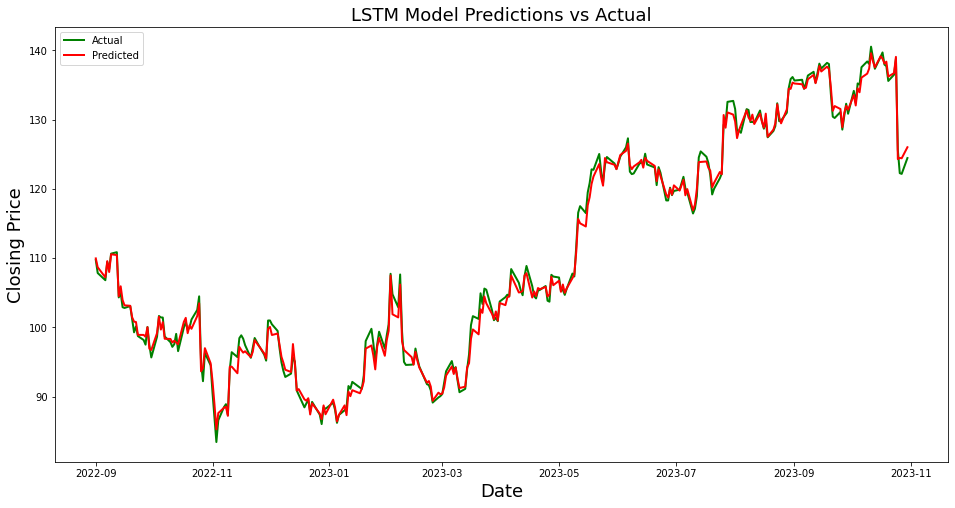

In [17]:
# Plot the predictions vs actual
plt.figure(figsize=(16,8))
plt.title('LSTM Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='green', label='Actual')
plt.plot(df1.index[-len(y_test):], lstm_pred_inv, linewidth=2, color='red', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

In [18]:
# Calculate the evaluation metrics for GRU model
mse_gru = mean_squared_error(y_test_inv, gru_pred_inv)
rms_gru = np.sqrt(mse_gru)
mae_gru = mean_absolute_error(y_test_inv, gru_pred_inv)
r2_gru = r2_score(y_test_inv, gru_pred_inv)

print("GRU Model Evaluation Metrics")
print("MSE: {:.4f}".format(mse_gru))
print("RMSE: {:.4f}".format(rms_gru))
print("MAE: {:.4f}".format(mae_gru))
print("R2 Score: {:.4f}".format(r2_gru))

GRU Model Evaluation Metrics
MSE: 0.9549
RMSE: 0.9772
MAE: 0.7991
R2 Score: 0.9963


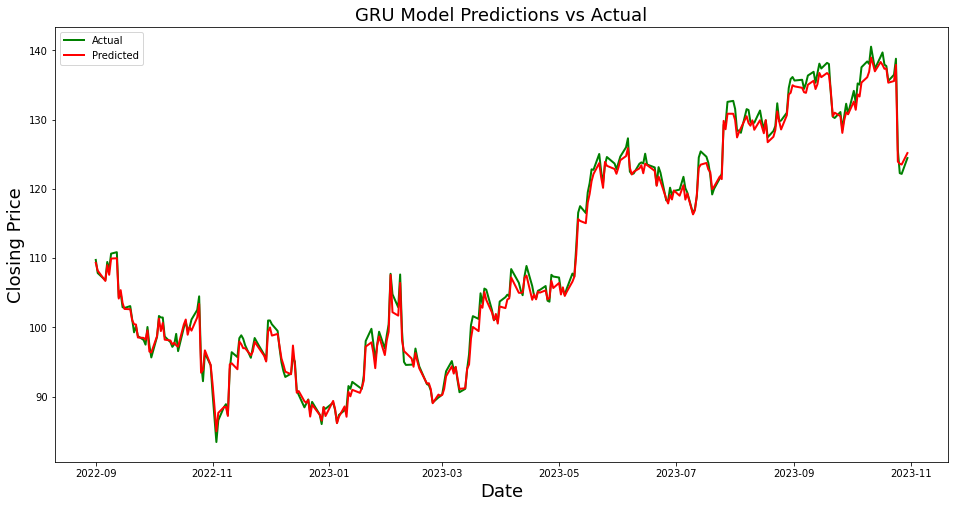

In [19]:
# Plot the predictions vs actual
plt.figure(figsize=(16,8))
plt.title('GRU Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='green', label='Actual')
plt.plot(df1.index[-len(y_test):], gru_pred_inv, linewidth=2, color='red', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

In [20]:
# Calculate the evaluation metrics for BiLSTM model
mse_bilstm = mean_squared_error(y_test_inv, bilstm_pred_inv)
rms_bilstm = np.sqrt(mse_bilstm)
mae_bilstm = mean_absolute_error(y_test_inv, bilstm_pred_inv)
r2_bilstm = r2_score(y_test_inv, bilstm_pred_inv)

print("BiLSTM Model Evaluation Metrics")
print("MSE: {:.4f}".format(mse_bilstm))
print("RMSE: {:.4f}".format(rms_bilstm))
print("MAE: {:.4f}".format(mae_bilstm))
print("R2 Score: {:.4f}".format(r2_bilstm))

BiLSTM Model Evaluation Metrics
MSE: 0.9915
RMSE: 0.9958
MAE: 0.7914
R2 Score: 0.9962


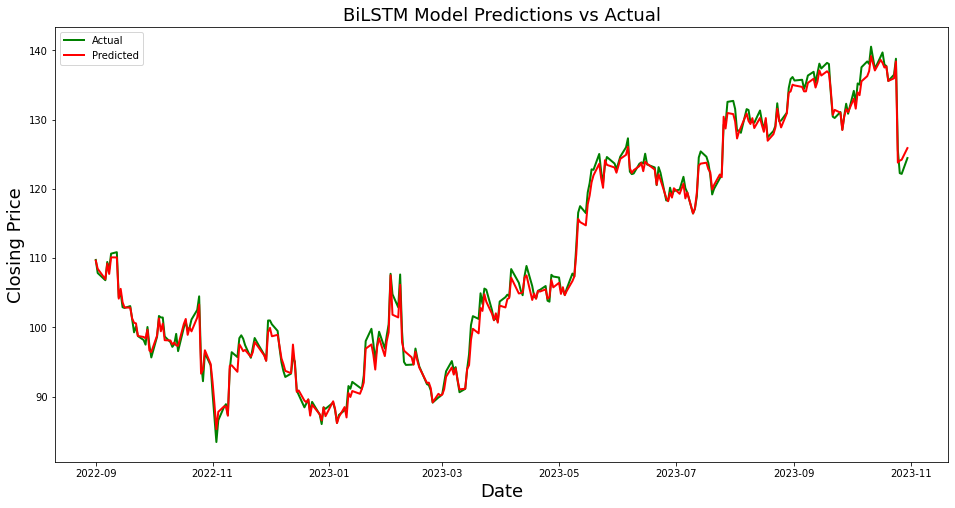

In [21]:
# Plot the predictions vs actual
plt.figure(figsize=(16,8))
plt.title('BiLSTM Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='green', label='Actual')
plt.plot(df1.index[-len(y_test):], bilstm_pred_inv, linewidth=2, color='red', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

In [22]:
# Create a stacked model
stacked_pred = np.column_stack((lstm_pred, gru_pred, bilstm_pred))

# Train final regressor based on stacked predictions
final_regressor = LinearRegression().fit(stacked_pred, y_test)

# Make predictions
final_pred = final_regressor.predict(stacked_pred)

# Inverse transform the predictions
final_pred_inv = target_scaler.inverse_transform(final_pred.reshape(-1,1))

In [23]:
# Calculate the evaluation metrics for stacked model
mse_stacked = mean_squared_error(y_test_inv, final_pred_inv)
rms_stacked = np.sqrt(mse_stacked)
mae_stacked = mean_absolute_error(y_test_inv, final_pred_inv)
r2_stacked = r2_score(y_test_inv, final_pred_inv)

print("LSTM-GRU-BiLSTM Stacked Model Evaluation Metrics")
print("MSE: {:.4f}".format(mse_stacked))
print("RMSE: {:.4f}".format(rms_stacked))
print("MAE: {:.4f}".format(mae_stacked))
print("R2 Score: {:.4f}".format(r2_stacked))

LSTM-GRU-BiLSTM Stacked Model Evaluation Metrics
MSE: 0.4504
RMSE: 0.6711
MAE: 0.5499
R2 Score: 0.9983


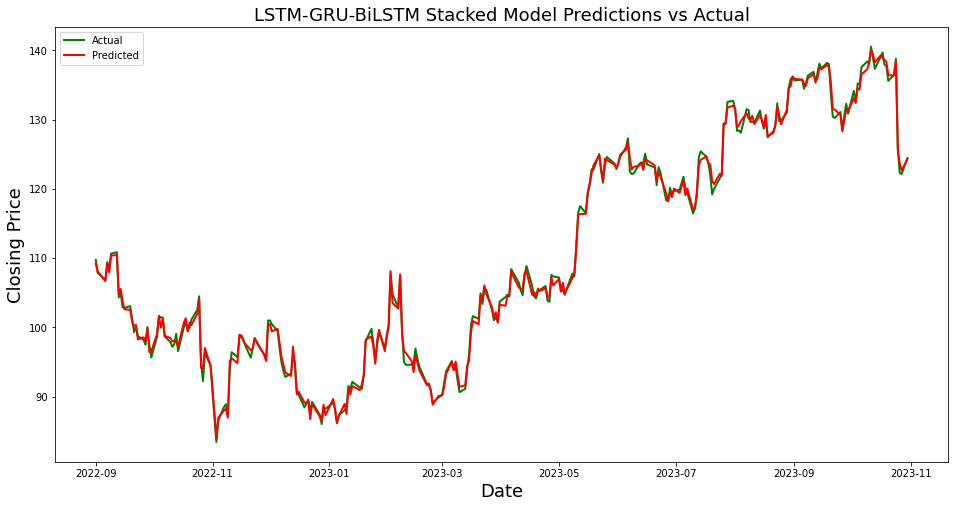

In [24]:
# Plot the predictions vs actual
plt.figure(figsize=(16,8))
plt.title('LSTM-GRU-BiLSTM Stacked Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='green', label='Actual')
plt.plot(df1.index[-len(y_test):], final_pred_inv, linewidth=2, color='red', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

In [25]:
# Build a dataframe with actual and predicted prices
df_pred = pd.DataFrame({'Date': df1.index[-len(y_test):], 'Actual': y_test_inv.flatten(),'LSTM': lstm_pred_inv.flatten(), 'GRU': gru_pred_inv.flatten(), 'BiLSTM': bilstm_pred_inv.flatten(), 'Stacked': final_pred_inv.flatten()})
df_pred

,Date,Actual,LSTM,GRU,BiLSTM,Stacked
0,2022-09-01,109.739998,109.962013,109.322784,109.639854,109.215599
1,2022-09-02,107.849998,108.685570,108.195473,108.463806,108.105598
2,2022-09-06,106.809998,107.220741,106.705505,106.953247,106.668083
3,2022-09-07,109.449997,109.570969,109.001427,109.223106,109.168900
4,2022-09-08,108.379997,107.998222,107.588028,107.712799,107.928986
...,...,...,...,...,...,...
287,2023-10-24,138.809998,139.079468,137.923782,138.415512,138.441849
288,2023-10-25,125.610001,124.312103,123.951210,123.806900,125.684746
289,2023-10-26,122.279999,124.479759,123.640564,124.087791,123.643768
290,2023-10-27,122.169998,124.424118,123.523842,124.217491,122.690346


In [26]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_lstm = []

# Predicting stock prices for the next 2 days
for _ in range(2):
    # Prepare the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predicting the next day stock price using the last feature data
    predicted_price = lstm_model.predict(last_features_lstm)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_lstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (LSTM Model):")
for i, price in enumerate(predicted_prices_lstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step
Predicted Closing Prices for the Next 2 Days (LSTM Model):
Day 1:126.023
Day 2:123.094


In [27]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_gru = []

# Predicting stock prices for the next 2 days
for x in range(2):
    # Prepare the last features for GRU input shape
    last_features_gru = last_features.reshape(1, 1, X_train_lstm.shape[2])

    # Predicting the next day stock price using the last feature data
    predicted_price = gru_model.predict(last_features_gru)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_gru.append(inverse_transformed_price)
    
    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (GRU Model):")
for i, price in enumerate(predicted_prices_gru):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step
Predicted Closing Prices for the Next 2 Days (GRU Model):
Day 1:125.181
Day 2:121.693


In [28]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_bilstm = []

# Predicting stock prices for the next 2 days
for x in range(2):
    # Prepare the last features for BiLSTM input shape
    last_features_bilstm = last_features.reshape(1, 1, X_train_lstm.shape[2])

    # Predicting the next day stock price using the last feature data
    predicted_price = bilstm_model.predict(last_features_bilstm)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_bilstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (BiLSTM Model):")
for i, price in enumerate(predicted_prices_bilstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
Predicted Closing Prices for the Next 2 Days (BiLSTM Model):
Day 1:125.897
Day 2:122.314


In [29]:
# Predict using stacked LSTM-GRU-BiLSTM model
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_stacked = []

# Predicting stock prices for the next 2 days
for x in range(2):
    # Prepare the last features for stacked model input shape
    last_features_stacked = last_features.reshape(1, 1, X_train_lstm.shape[2])

    # Predicting the next day stock price using the last feature data
    predicted_price = final_regressor.predict(np.column_stack((lstm_model.predict(last_features_stacked), gru_model.predict(last_features_stacked), bilstm_model.predict(last_features_stacked))))

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_stacked.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (Stacked Model):")
for i, price in enumerate(predicted_prices_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 22ms/step
Predicted Closing Prices for the Next 2 Days (Stacked Model):
Day 1:124.267
Day 2:121.973


In [30]:
# LSTM model with hyperparameter tuning
# Define the parameter grid
param_grid = {'optimizer': ['Adam','RMSprop','SGD']}

# Grid search on LSTM
grid = GridSearchCV(estimator=LSTMEstimator(), param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train_lstm, y_train)

# Print the best parameters
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)
print("Best estimator: ", grid_result.best_estimator_)

# Using the best estimator for LSTM from the grid search
best_lstm_model = grid_result.best_estimator_

# Predicting the test data
pred_best_lstm = best_lstm_model.predict(X_test_lstm)

# Inverse transform the predictions
pred_best_lstm_inv = target_scaler.inverse_transform(pred_best_lstm.reshape(-1,1))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters:  {'optimizer': 'Adam'}
Best score:  0.9870173060558531
Best estimator:  LSTMEstimator(optimizer='Adam')
10/10 [==============================] - 0s 1ms/step


In [31]:
# Calculate the evaluation metrics for LSTM model
mse_best_lstm = mean_squared_error(y_test_inv, pred_best_lstm_inv)
rms_best_lstm = np.sqrt(mse_best_lstm)
mae_best_lstm = mean_absolute_error(y_test_inv, pred_best_lstm_inv)
r2_best_lstm = r2_score(y_test_inv, pred_best_lstm_inv)

print("Tuned LSTM Model Evaluation Metrics")
print("MSE: {:.4f}".format(mse_best_lstm))
print("RMSE: {:.4f}".format(rms_best_lstm))
print("MAE: {:.4f}".format(mae_best_lstm))
print("R2 Score: {:.4f}".format(r2_best_lstm))

Tuned LSTM Model Evaluation Metrics
MSE: 0.9491
RMSE: 0.9742
MAE: 0.7771
R2 Score: 0.9964


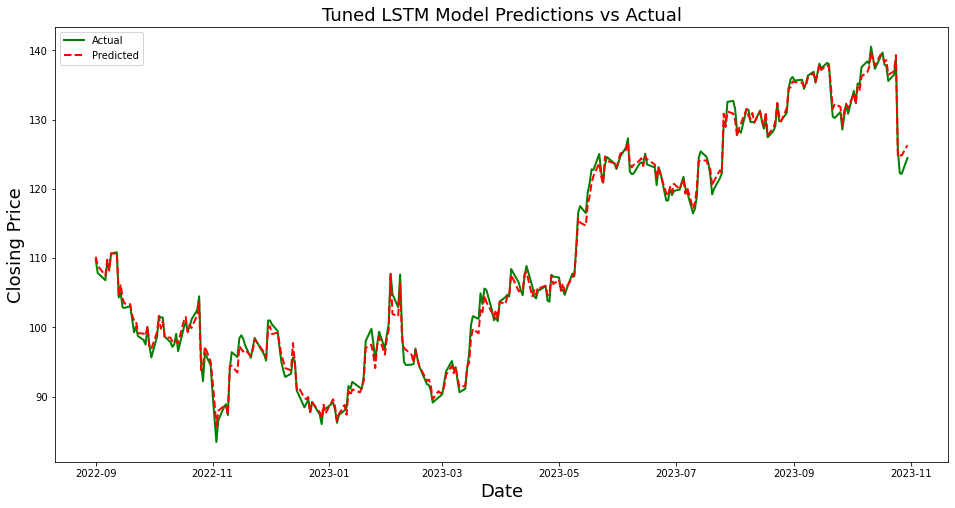

In [32]:
# Plot the predictions vs actual
plt.figure(figsize=(16,8))
plt.title('Tuned LSTM Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='green', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], pred_best_lstm_inv, linewidth=2, color='red', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

In [33]:
# GRU model with hyperparameter tuning
# Define the parameter grid
param_grid = {'optimizer': ['Adam','RMSprop','SGD']}
# Grid search on GRU
grid = GridSearchCV(estimator=GRUEstimator(), param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train_lstm, y_train)

# Print the best parameters
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)
print("Best estimator: ", grid_result.best_estimator_)

# Using the best estimator for GRU from the grid search
best_gru_model = grid_result.best_estimator_

# Predicting the test data
pred_best_gru = best_gru_model.predict(X_test_lstm)

# Inverse transform the predictions
pred_best_gru_inv = target_scaler.inverse_transform(pred_best_gru.reshape(-1,1))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters:  {'optimizer': 'Adam'}
Best score:  0.9869918463249844
Best estimator:  GRUEstimator(optimizer='Adam')
10/10 [==============================] - 0s 1ms/step


In [34]:
# Calculate the evaluation metrics for GRU model
mse_best_gru = mean_squared_error(y_test_inv, pred_best_gru_inv)
rms_best_gru = np.sqrt(mse_best_gru)
mae_best_gru = mean_absolute_error(y_test_inv, pred_best_gru_inv)
r2_best_gru = r2_score(y_test_inv, pred_best_gru_inv)

print("Tuned GRU Model Evaluation Metrics")
print("MSE: {:.4f}".format(mse_best_gru))
print("RMSE: {:.4f}".format(rms_best_gru))
print("MAE: {:.4f}".format(mae_best_gru))
print("R2 Score: {:.4f}".format(r2_best_gru))

Tuned GRU Model Evaluation Metrics
MSE: 2.4358
RMSE: 1.5607
MAE: 1.3565
R2 Score: 0.9907


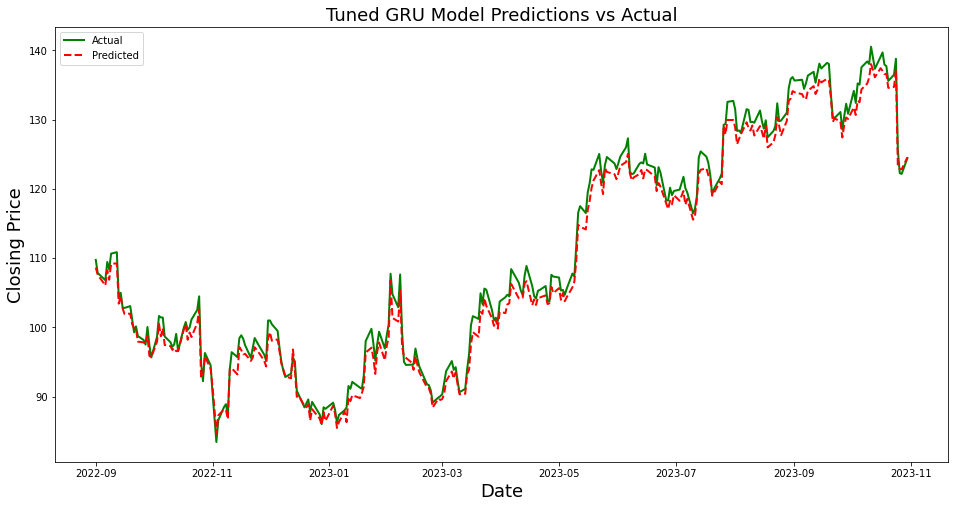

In [35]:
# Plot the predictions vs actual
plt.figure(figsize=(16,8))
plt.title('Tuned GRU Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='green', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], pred_best_gru_inv, linewidth=2, color='red', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

In [36]:
# BiLSTM model with hyperparameter tuning
# Define the parameter grid
param_grid = {'optimizer': ['Adam','RMSprop','SGD']}
# Grid search on BiLSTM
grid = GridSearchCV(estimator=BiLSTMEstimator(), param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train_lstm, y_train)

# Print the best parameters
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)
print("Best estimator: ", grid_result.best_estimator_)

# Using the best estimator for BiLSTM from the grid search
best_bilstm_model = grid_result.best_estimator_

# Predicting the test data
pred_best_bilstm = best_bilstm_model.predict(X_test_lstm)

# Inverse transform the predictions
pred_best_bilstm_inv = target_scaler.inverse_transform(pred_best_bilstm.reshape(-1,1))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters:  {'optimizer': 'Adam'}
Best score:  0.9902167899019375
Best estimator:  BiLSTMEstimator(optimizer='Adam')
10/10 [==============================] - 1s 1ms/step


In [37]:
# Calculate the evaluation metrics for BiLSTM model
mse_best_bilstm = mean_squared_error(y_test_inv, pred_best_bilstm_inv)
rms_best_bilstm = np.sqrt(mse_best_bilstm)
mae_best_bilstm = mean_absolute_error(y_test_inv, pred_best_bilstm_inv)
r2_best_bilstm = r2_score(y_test_inv, pred_best_bilstm_inv)

print("Tuned BiLSTM Model Evaluation Metrics")
print("MSE: {:.4f}".format(mse_best_bilstm))
print("RMSE: {:.4f}".format(rms_best_bilstm))
print("MAE: {:.4f}".format(mae_best_bilstm))
print("R2 Score: {:.4f}".format(r2_best_bilstm))

Tuned BiLSTM Model Evaluation Metrics
MSE: 1.5225
RMSE: 1.2339
MAE: 1.0292
R2 Score: 0.9942


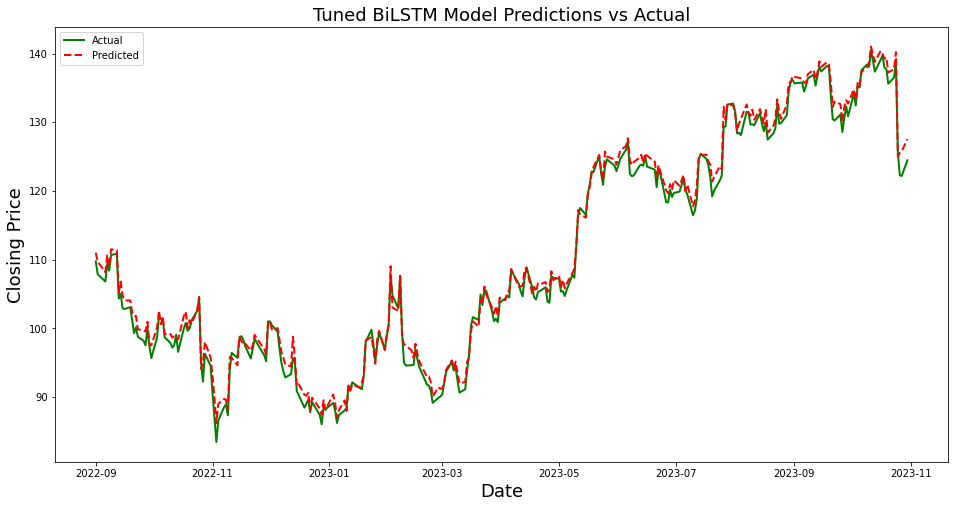

In [39]:
# Plot the predictions vs actual
plt.figure(figsize=(16,8))
plt.title('Tuned BiLSTM Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='green', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], pred_best_bilstm_inv, linewidth=2, color='red', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

In [40]:
# Create a stacked model
stacked_tuned_pred = np.column_stack((pred_best_lstm, pred_best_gru, pred_best_bilstm))

# Train final regressor based on stacked predictions
final_tuned_regressor = LinearRegression().fit(stacked_tuned_pred, y_test)

# Make predictions
final_tuned_pred = final_tuned_regressor.predict(stacked_tuned_pred)

# Inverse transform the predictions
final_tuned_pred_inv = target_scaler.inverse_transform(final_tuned_pred.reshape(-1,1))

In [41]:
# Calculate the evaluation metrics for stacked model
mse_stacked = mean_squared_error(y_test_inv, final_tuned_pred_inv)
rms_stacked = np.sqrt(mse_stacked)
mae_stacked = mean_absolute_error(y_test_inv, final_tuned_pred_inv)
r2_stacked = r2_score(y_test_inv, final_tuned_pred_inv)

print("Tuned LSTM-GRU-BiLSTM Model Evaluation Metrics")
print("MSE: {:.4f}".format(mse_stacked))
print("RMSE: {:.4f}".format(rms_stacked))
print("MAE: {:.4f}".format(mae_stacked))
print("R2 Score: {:.4f}".format(r2_stacked))

Tuned LSTM-GRU-BiLSTM Model Evaluation Metrics
MSE: 0.5955
RMSE: 0.7717
MAE: 0.6018
R2 Score: 0.9977


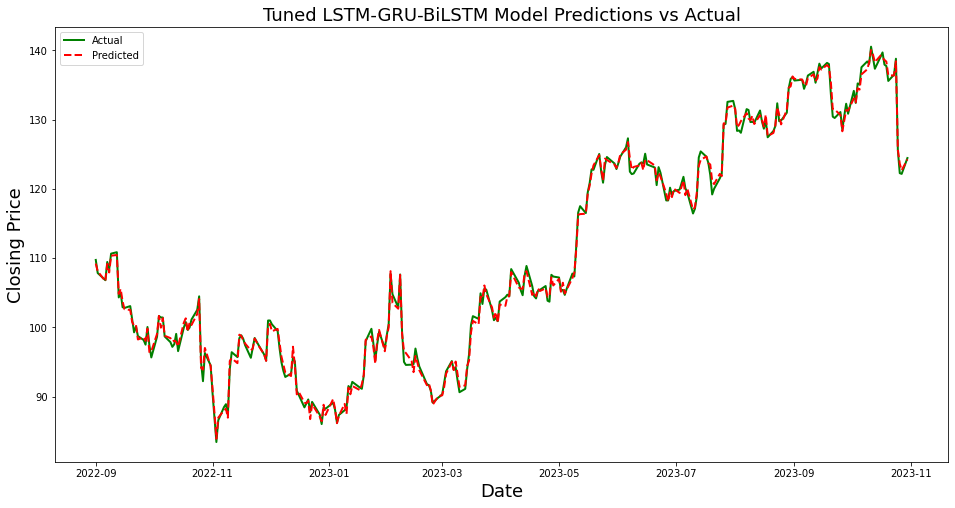

In [42]:
# Plot the predictions vs actual
plt.figure(figsize=(16,8))
plt.title('Tuned LSTM-GRU-BiLSTM Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='green', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], final_pred_inv, linewidth=2, color='red', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

In [43]:
# Build a dataframe with actual and predicted prices
df_pred_1 = pd.DataFrame({'Date': df1.index[-len(y_test):], 'Actual': y_test_inv.flatten(),'Tuned LSTM': pred_best_lstm_inv.flatten(), 'Tuned GRU': pred_best_gru_inv.flatten(), 'Tuned BiLSTM': pred_best_bilstm_inv.flatten(), 'Tuned Stacked': final_tuned_pred_inv.flatten()})
df_pred_1

,Date,Actual,Tuned LSTM,Tuned GRU,Tuned BiLSTM,Tuned Stacked
0,2022-09-01,109.739998,110.200012,108.640007,111.002266,109.736076
1,2022-09-02,107.849998,108.912704,107.596527,109.690804,108.785042
2,2022-09-06,106.809998,107.473251,106.052628,108.162231,107.080872
3,2022-09-07,109.449997,109.780548,108.235779,110.621162,109.353394
4,2022-09-08,108.379997,108.197060,106.882271,108.945923,108.032402
...,...,...,...,...,...,...
287,2023-10-24,138.809998,139.327820,137.167862,140.198792,138.787354
288,2023-10-25,125.610001,124.652168,123.240807,125.028679,124.567894
289,2023-10-26,122.279999,124.877975,122.863258,125.520920,124.008728
290,2023-10-27,122.169998,124.808273,122.839684,125.756081,124.205284


In [44]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_lstm = []

# Predicting stock prices for the next 2 days
for _ in range(2):
    # Prepare the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predicting the next day stock price using the last feature data
    predicted_price = best_lstm_model.predict(last_features_lstm)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_lstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (Best LSTM Model):")
for i, price in enumerate(predicted_prices_lstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 26ms/step
Predicted Closing Prices for the Next 2 Days (Best LSTM Model):
Day 1:126.312
Day 2:123.510


In [45]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_gru = []

# Predicting stock prices for the next 2 days
for x in range(2):
    # Prepare the last features for GRU input shape
    last_features_gru = last_features.reshape(1, 1, X_train_lstm.shape[2])

    # Predicting the next day stock price using the last feature data
    predicted_price = best_gru_model.predict(last_features_gru)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_gru.append(inverse_transformed_price)
    
    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (Best GRU Model):")
for i, price in enumerate(predicted_prices_gru):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step
Predicted Closing Prices for the Next 2 Days (Best GRU Model):
Day 1:124.567
Day 2:121.026


In [46]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_bilstm = []

# Predicting stock prices for the next 2 days
for x in range(2):
    # Prepare the last features for BiLSTM input shape
    last_features_bilstm = last_features.reshape(1, 1, X_train_lstm.shape[2])

    # Predicting the next day stock price using the last feature data
    predicted_price = best_bilstm_model.predict(last_features_bilstm)

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_bilstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (Best BiLSTM Model):")
for i, price in enumerate(predicted_prices_bilstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 37ms/step
Predicted Closing Prices for the Next 2 Days (Best BiLSTM Model):
Day 1:127.546
Day 2:124.412


In [47]:
# Predict using stacked LSTM-GRU-BiLSTM model
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_stacked = []

# Predicting stock prices for the next 2 days
for x in range(2):
    # Prepare the last features for stacked model input shape
    last_features_stacked = last_features.reshape(1, 1, X_train_lstm.shape[2])

    # Predicting the next day stock price using the last feature data
    predicted_price = final_tuned_regressor.predict(np.column_stack((best_lstm_model.predict(last_features_stacked), best_gru_model.predict(last_features_stacked), best_bilstm_model.predict(last_features_stacked))))

    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_stacked.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (Best Stacked Model):")
for i, price in enumerate(predicted_prices_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step
Predicted Closing Prices for the Next 2 Days (Best Stacked Model):
Day 1:126.290
Day 2:123.048
